In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
from scipy.optimize import curve_fit

In [48]:
ACMBlue = '#00cfe6'
ACMYellow = '#ffd600'
ACMOrange = '#fc9200'
ACMRed = '#ff1924'
ACMLightBlue = '#82fcff'
ACMGreen = '#a5cf00'
ACMPurple = '#6200d9'
ACMDarkBlue = '#0055c9'
    
    
def setup_ax(ax):    
    locator = mdates.YearLocator()
    ax.xaxis.set_minor_locator(locator)
    ax.set_xticks(pd.DatetimeIndex(['{}-01-01'.format(year) for year in range(1991, 2022, 3)]))
    year_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(year_fmt)
    
    ax.grid(linestyle='dotted', which='both')
    #ax.set_xlim(left=pd.Timestamp('1991-01-01'), right=pd.Timestamp('2021-01-01'))
    

def exp_fit(y_data):
    def _exp(t, a, b, c):
        return a*np.exp(b*t) + c
    
    x_data = range(0, len(y_data))
    
    params, params_covariance = curve_fit(_exp, x_data, y_data, p0=[0, 0, 0])
    y_fit = _exp(x_data, params[0], params[1], params[2])
    return y_fit, params

default_ratio = (np.sqrt(5.0) - 1.0) / 2.0
default_width = 6
default_height = default_ratio * default_width

In [49]:
activities = pd.read_hdf('../data/openhub.h5', key='filled_activities', mode='r')
activities.shape

(6011057, 8)

# Outliers

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/The_Normal_Distribution.svg/1920px-The_Normal_Distribution.svg.png)

In [50]:
activities['loc_added'] = activities.code_added + activities.comments_added

In [51]:
code_added = activities.loc_added[activities.loc_added.transform(lambda x: (x - x.mean()) / x.std()).abs()<=3]
commits = activities.commits[activities.commits.transform(lambda x: (x - x.mean()) / x.std()).abs()<=3]
contributors = activities.contributors[activities.contributors.transform(lambda x: (x - x.mean()) / x.std()).abs()<=3]

# Outliers' impact

In [52]:
activities.index.get_level_values(1).nunique()

172833

In [53]:
activities.code_added.sum(), activities.code_added.sum()-code_added.sum(), code_added.max()

(34487694594, 13045874360, 553097)

In [54]:
activities.commits.sum(), activities.commits.sum()-commits.sum(), commits.max()

(114794355, 29272733, 708)

In [55]:
activities.contributors.sum(), activities.contributors.sum()-contributors.sum(), contributors.max()

(8549545, 2542617, 26)

# Commits

In [56]:
commits_per_month = commits.groupby(level=[0]).sum()

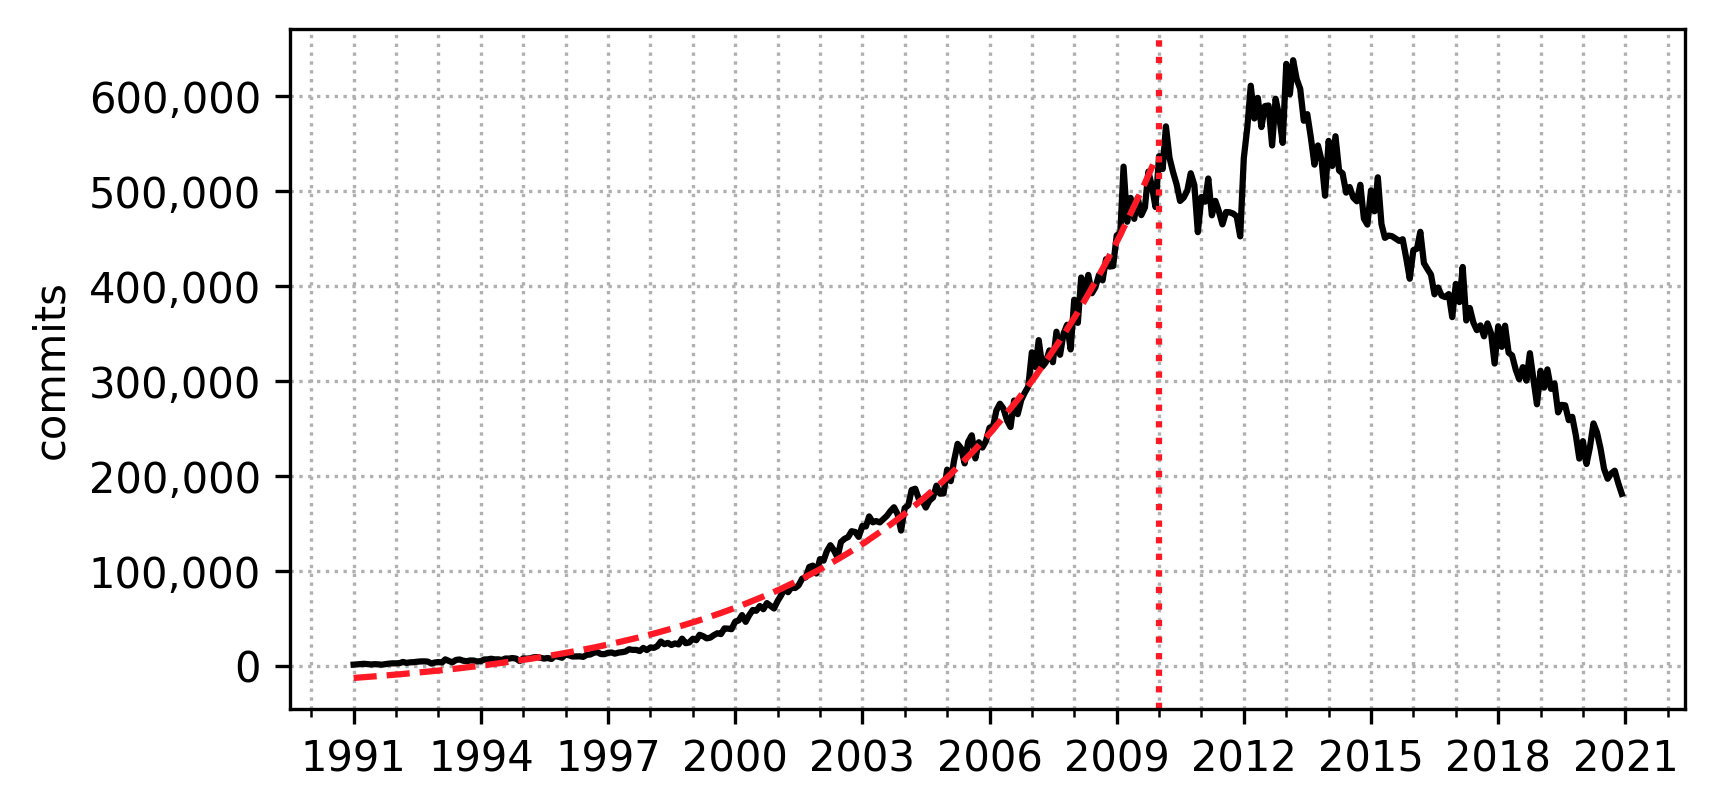

In [57]:
exp_fit_end = (2010-1991)*12
y_fit, params = exp_fit(commits_per_month[0:exp_fit_end])

fig = plt.figure(figsize=(default_width, 0.5*default_width), dpi=300)
ax = fig.add_subplot()

ax.plot(commits_per_month, label='Commits per month', color='black')

ax.plot(commits_per_month.index[:exp_fit_end], y_fit, color=ACMRed, linestyle='dashed', label='Exponential model')
ax.axvline(commits_per_month.index[exp_fit_end], linestyle='dotted', color=ACMRed)

setup_ax(ax)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('commits')

plt.savefig('../reports/commits.eps', bbox_inches='tight', pad_inches=0)


In [58]:
commits_per_month.to_csv('../reports/commits.csv')
pd.Series(y_fit, index=commits_per_month.index[:exp_fit_end]).rename('exp').to_csv('../reports/commits_exp.csv')

# Contributors

In [59]:
contributors_per_month = contributors.groupby(level=[0]).sum()

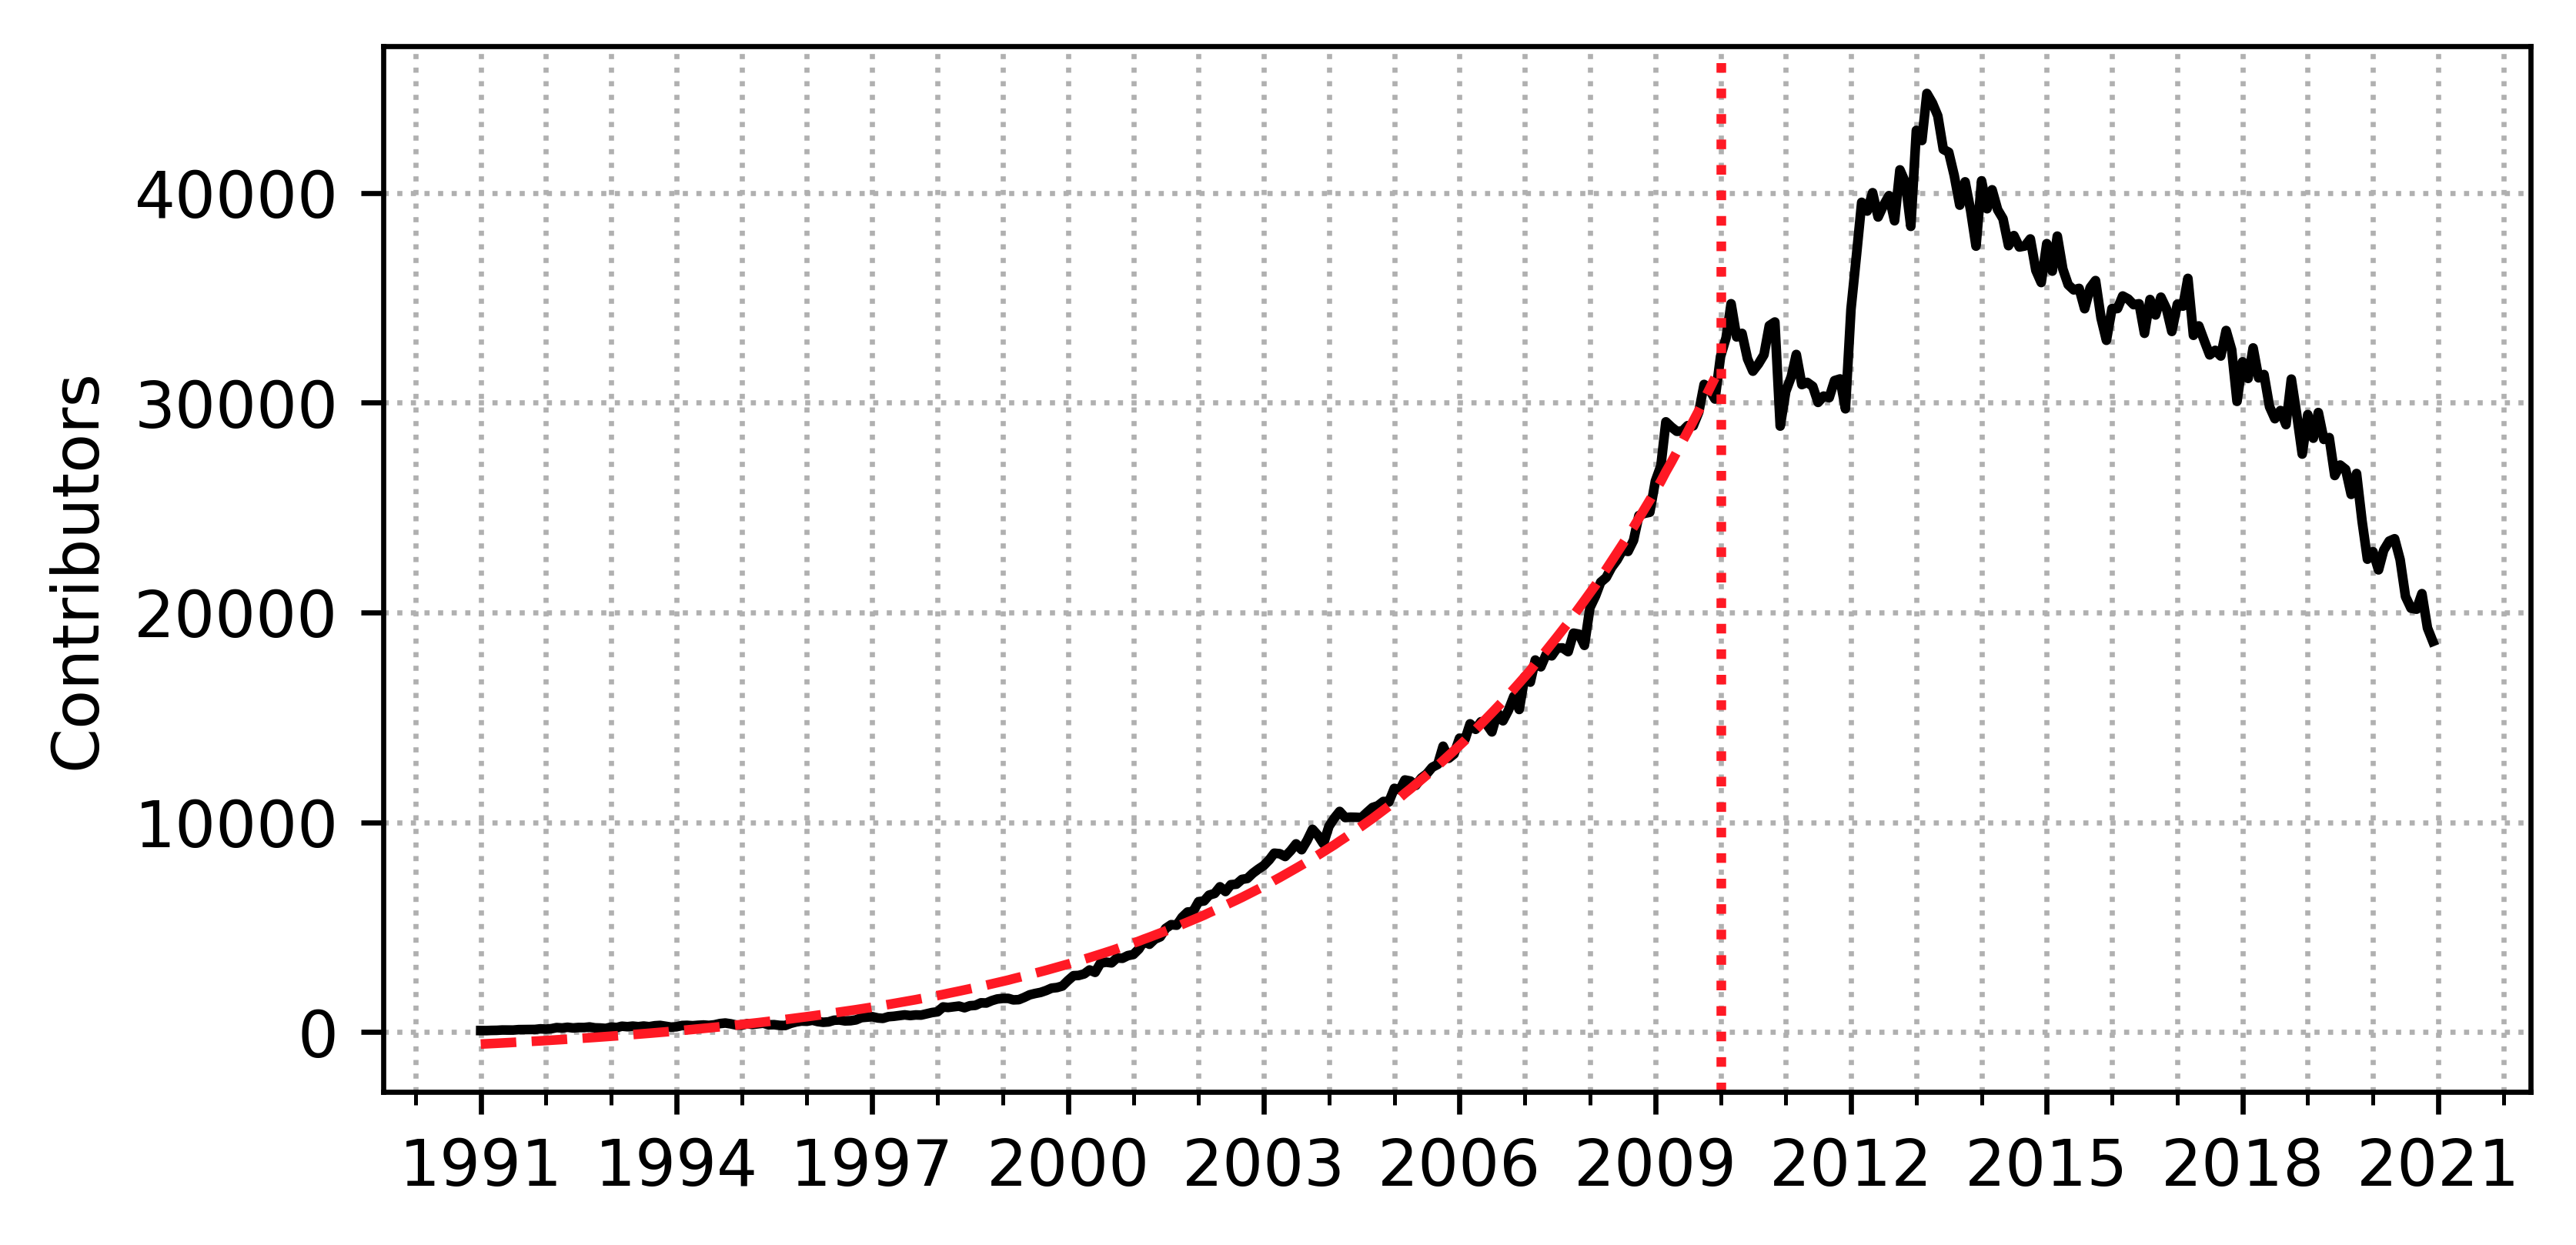

In [60]:
exp_fit_end = (2010-1991)*12
y_fit, params = exp_fit(contributors_per_month[:exp_fit_end])

fig, ax = plt.subplots(figsize=(default_width, 0.5*default_width), dpi=600)

ax.plot(contributors_per_month, label='Total contributors', color='black')

ax.plot(contributors_per_month.index[:exp_fit_end], y_fit, color=ACMRed, linestyle='dashed', label='Exponential model')
ax.axvline(contributors_per_month.index[exp_fit_end], linestyle='dotted', color=ACMRed, label='sd')

setup_ax(ax)
ax.set_ylabel('Contributors')

plt.savefig('../reports/contributors.eps', bbox_inches='tight', pad_inches=0)

In [61]:
contributors_per_month.to_csv('../reports/contributors.csv')
pd.Series(y_fit, index=contributors_per_month.index[:exp_fit_end]).rename('exp').to_csv('../reports/contributors_exp.csv')

# LoC

In [62]:
loc_per_month = code_added.groupby(level=0).sum()

In [63]:
exp_fit_end = (2010-1991)*12
y_fit, params = exp_fit(loc_per_month[:exp_fit_end])

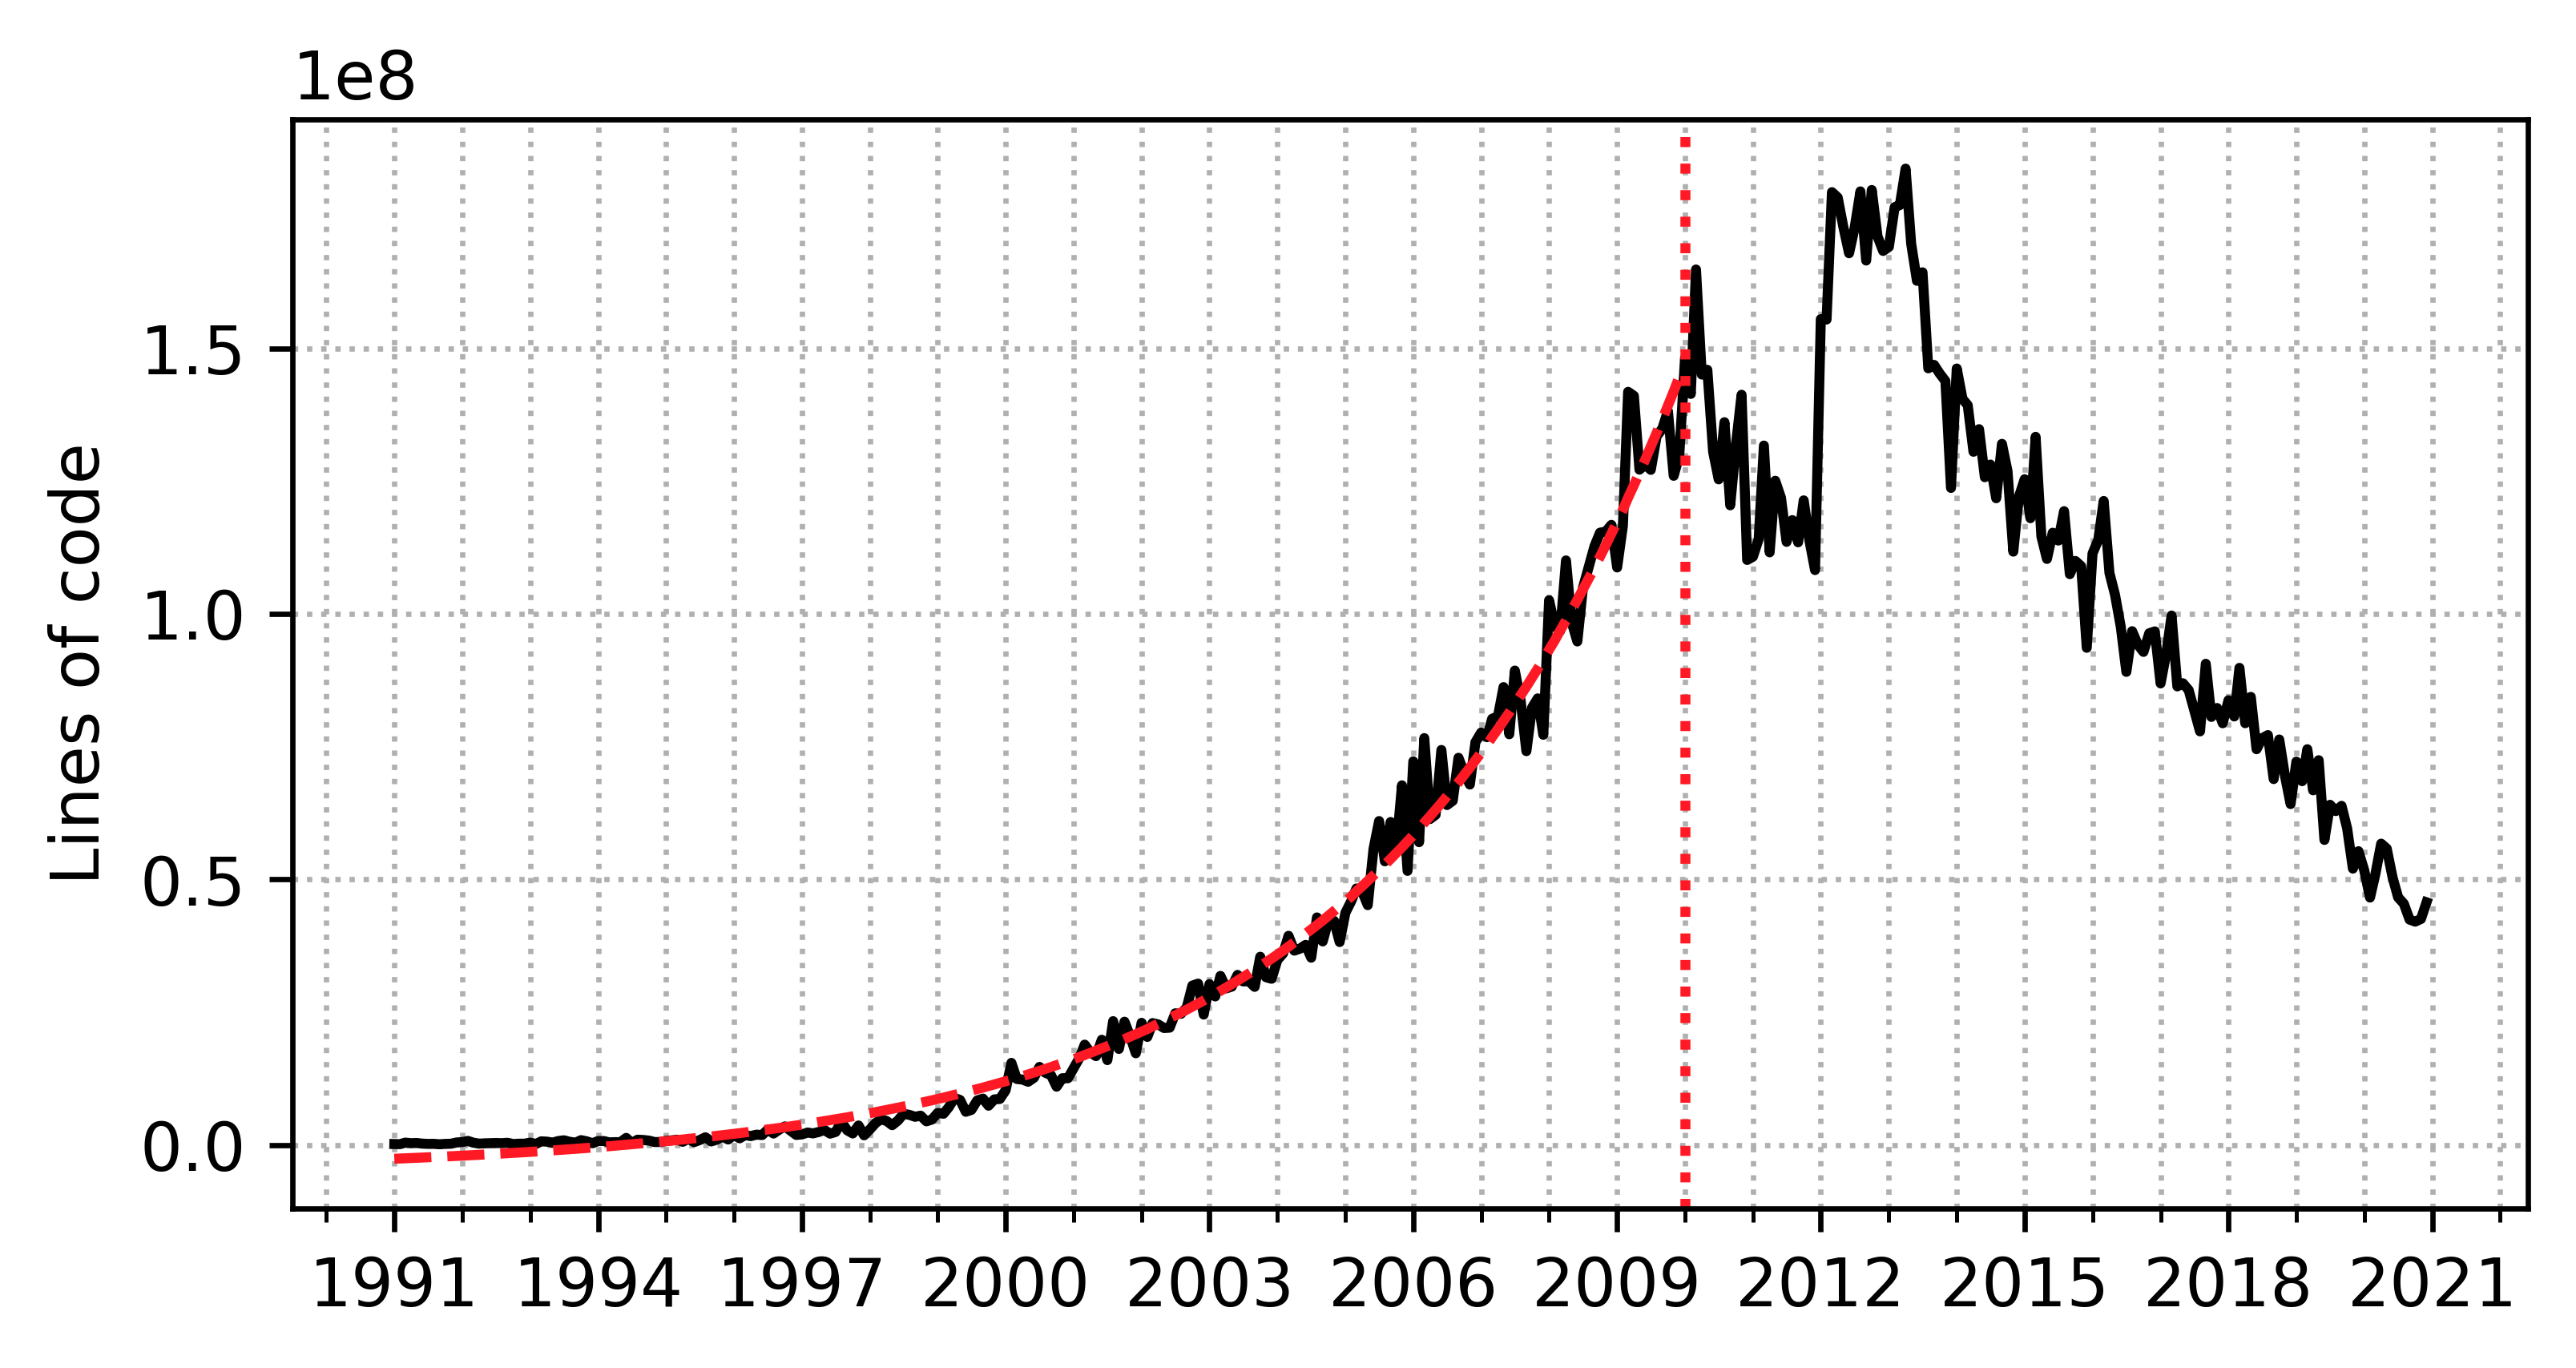

In [64]:
fig = plt.figure(figsize=(default_width, 0.5*default_width), dpi=600)
ax = fig.add_subplot()

ax.plot(loc_per_month, label='Mean', color='black')

ax.plot(loc_per_month.index[:exp_fit_end], y_fit, color=ACMRed, linestyle='dashed', label='Exponential model for lines of code')
ax.axvline(loc_per_month.index[exp_fit_end], linestyle='dotted', color=ACMRed)
    
setup_ax(ax)
ax.set_ylabel('Lines of code');

plt.savefig('../reports/loc.eps', bbox_inches='tight', pad_inches=0)

In [65]:
loc_per_month.to_csv('../reports/loc.csv')
pd.Series(y_fit, index=loc_per_month.index[:exp_fit_end]).rename('exp').to_csv('../reports/loc_exp.csv')

# Projects

In [66]:
valid_projects = pd.read_hdf('../data/openhub.h5', key='valid_projects', mode='r')

In [67]:
valid_projects.dtypes

updated_at    datetime64[ns]
min_month     datetime64[ns]
max_month     datetime64[ns]
dtype: object

In [68]:
s = valid_projects.min_month.reset_index(level=0).min_month.groupby(level=0).min()
date_index = pd.date_range('1991-01-01', '2020-12-01', freq='MS')
new_projects_per_month = pd.Series(s.index, index=s.values).groupby(level=0).nunique().reindex(date_index, fill_value=0)

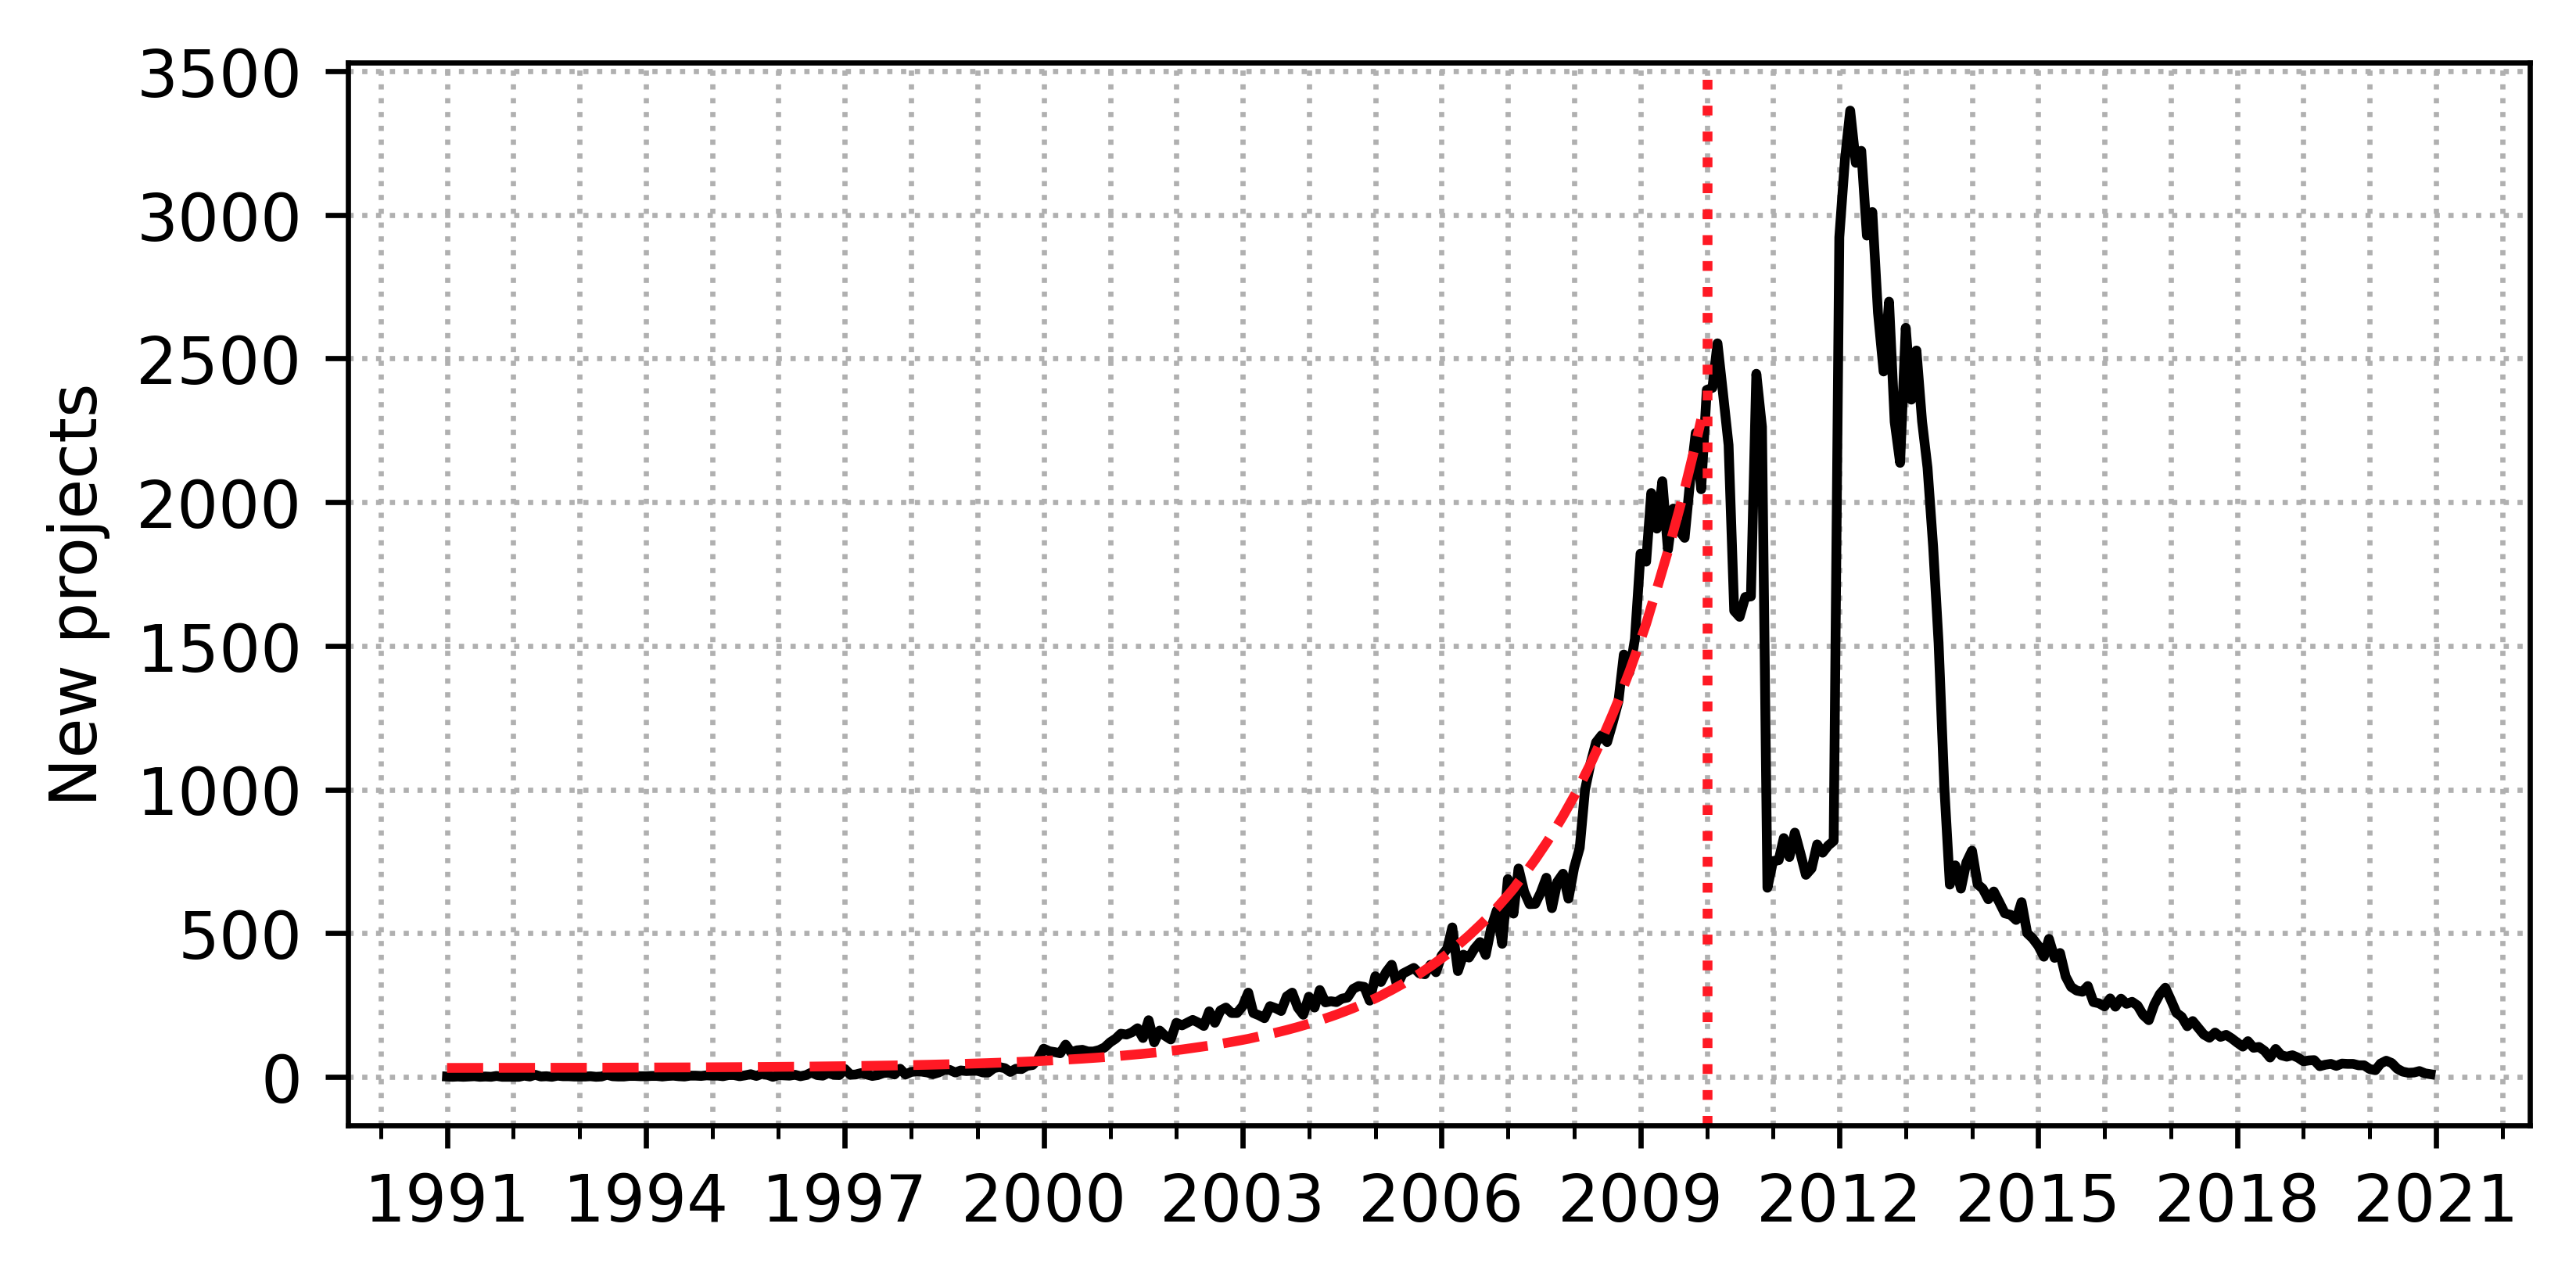

In [69]:
y_fit_end = (2010-1991)*12
y_fit, params = exp_fit(new_projects_per_month[:y_fit_end])

fig, ax = plt.subplots(figsize=(default_width, 0.5*default_width), dpi=600)

ax.plot(new_projects_per_month, color='black')
ax.plot(new_projects_per_month.index[0:y_fit_end], y_fit, color=ACMRed, linestyle='dashed')
ax.axvline(new_projects_per_month.index[y_fit_end], linestyle='dotted', color=ACMRed)

ax.set_ylabel('New projects')

setup_ax(ax)
plt.savefig('../reports/projects.eps', bbox_inches='tight', pad_inches=0)

In [70]:
loc_per_month.to_csv('../reports/projects.csv')
pd.Series(y_fit, index=loc_per_month.index[:exp_fit_end]).rename('exp').to_csv('../reports/projects_exp.csv')

# Overview

In [71]:
norm_commits = commits_per_month.apply(lambda x: x/commits_per_month.max())
norm_contributors = contributors_per_month.apply(lambda x: x/contributors_per_month.max())
norm_loc = loc_per_month.apply(lambda x: x/loc_per_month.max())

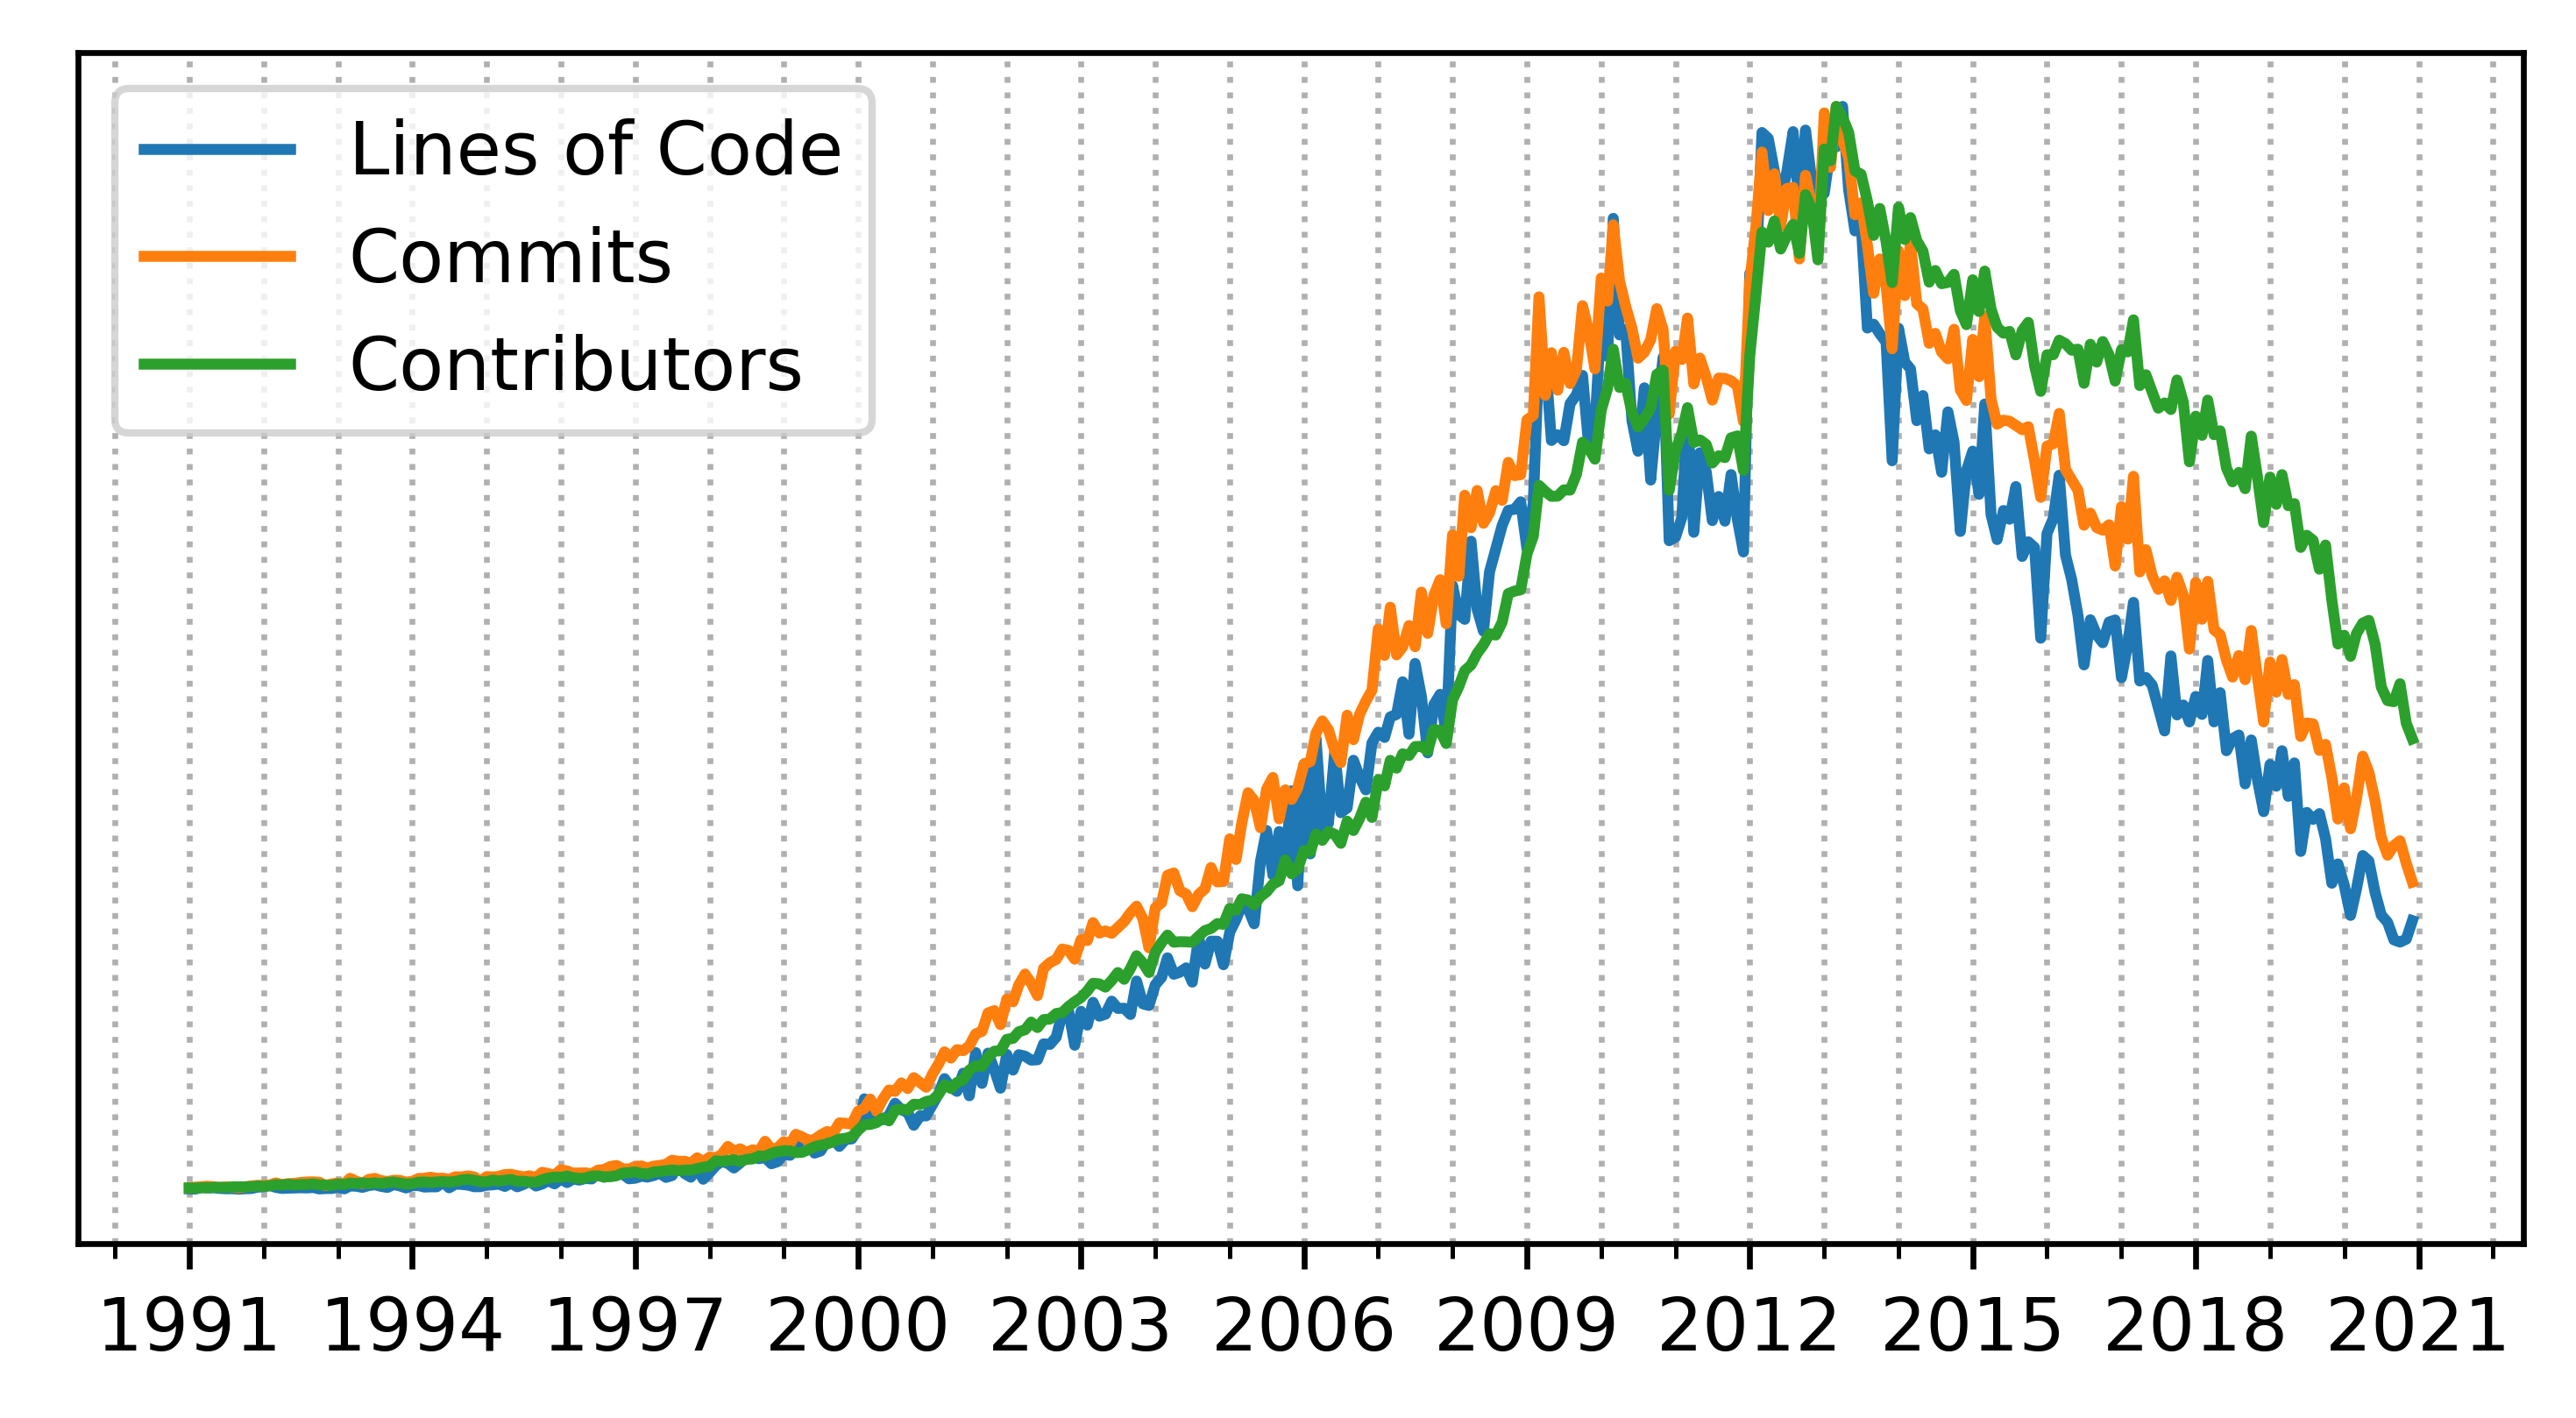

In [73]:
fig, ax = plt.subplots(figsize=(default_width, 0.5*default_width), dpi=600)

ax.plot(norm_loc, label='Lines of Code')
ax.plot(norm_commits, label='Commits')
ax.plot(norm_contributors, label='Contributors')

ax.legend(loc='upper left')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])

setup_ax(ax)